# Fractal Embeddings Demo Notebook

This walks through some of the functionality contained in this repo with example results.

#### Main Point of This File
- To describe code functionality 
- To steal code snippets and shell commands
- A playground for development

# Creating Embeddings from Text Directories

The `embed_text_cohere.py` script takes a directory containing text files and generates embeddings using Cohere's API. The embeddings are saved as a DataFrame in a `.csv` file. This script supports recursive search for `.md` files in the input directory and can handle API rate limits.

Here's an example of how to run the script from the command line:

```bash
python src/embed_text_cohere.py -i ./data -e output_embeddings.csv -c config.ini
```

Review the script to understand the command line arguments. Briefly, the -i input dir is being stored in the -e embedding file and a -n npz file, with an api key found in -c config.ini

Now let's run the script using the provided data directories.

In [8]:
!python src/embed_text_cohere.py -i ./data/memory -e ./demo_data/memory_embeddings.csv -n -c config.ini
!python src/embed_text_cohere.py -i ./data/my-second-brain -e ./demo_data/my_second_brain_embeddings.csv -n -c config.ini

Embedding text: 100%|█████████████████████████████| 7/7 [00:14<00:00,  2.08s/it]


After running the above commands, you should have two `.csv` files containing embeddings for your data: `memory_embeddings.csv`and `my_second_brain_embeddings.csv`. You can load these files using pandas and visualize the embeddings or perform further analysis.

In [35]:
import pandas as pd

memory_embeddings_df = pd.read_csv('./demo_data/memory_embeddings.csv')
my_second_brain_embeddings_df = pd.read_csv('./demo_data/my_second_brain_embeddings.csv')

memory_embeddings_df.head()


,filename,index,chunk_text,embedding,links
0,Heretics of Dune,0,# Heretics of Dune ![rw-book-cover](https://im...,"[1.4345703, -0.37695312, 0.18273926, -0.636718...","['Frank Herbert', 'Books', 'Psychedelics', 'Sc..."
1,CSC 581,1,"--- **Status::** #🗺️ **Tags::** [[MOC]], [[Win...","[0.92285156, -0.5053711, 0.7392578, 0.30615234...","['MOC', 'Winter 2023']"
2,Tensorflow Mac M1,2,## AAAh [Good post on SO](https://stackoverflo...,"[1.8417969, 0.6347656, 0.027954102, 1.9462891,...",['Programming Notes']
3,Tensorflow Mac M1,2,optimizer=tf.keras.optimizers.legacy.Adam(lear...,"[3.5527344, 0.11090088, 0.33618164, 1.2988281,...",['Programming Notes']
4,Snowflake,3,## Snowflake Here's to you - You doubters of m...,"[0.80810547, 1.3378906, -0.18164062, 0.0483093...","['Poetry', 'My Writings']"


In [36]:
my_second_brain_embeddings_df.head()

,filename,index,chunk_text,embedding,links
0,Welcome in my mind 🧠,0,"## Who I am? I'm **Anthony**, a `Date.today.ye...","[0.8691406, -0.91748047, 1.21875, -1.6054688, ...",[]
1,Welcome in my mind 🧠,0,want. Here's a hint: you can just watch the su...,"[0.75634766, -0.33984375, 0.22790527, -1.01953...",[]
2,README,1,*You'll have a better browsing experience of t...,"[1.0322266, -1.8320312, 0.36694336, -0.9697265...",[]
3,README,1,deep into a wide variety of fields and engage ...,"[1.2236328, -0.5444336, -0.43579102, 0.4089355...",[]
4,Contact me 💌,2,## Want to get in touch? 😊 I'd love to hear fr...,"[-0.6777344, 0.38598633, 1.8916016, -2.1796875...",[]


# Dimensionality Reduction

We'll perform dimensionality reduction on the embeddings to visualize them in a lower-dimensional space. The `dimensionality_reduction.py` script can perform PCA, t-SNE, and UMAP dimensionality reduction methods. 

### Combining Embeddings

Before performing dimensionality reduction, let's combine the two sets of embeddings into a single file. We'll use numpy to load, concatenate, and save the embeddings.

In [37]:
import numpy as np

memory_embeddings = np.load('./demo_data/memory_embeddings.npz', allow_pickle=True)
my_second_brain_embeddings = np.load('./demo_data/my_second_brain_embeddings.npz', allow_pickle=True)

combined_embeddings = np.concatenate((memory_embeddings['embeddings'], my_second_brain_embeddings['embeddings']), axis=0)
combined_filenames = np.concatenate((memory_embeddings['filenames'], my_second_brain_embeddings['filenames']), axis=0)
np.savez('./demo_data/combined_embeddings.npz', filenames=combined_filenames, embeddings=combined_embeddings)

### Running Dimensionality Reduction
Now we'll run the dimensionality_reduction.py script on the combined embeddings. This script supports PCA, t-SNE, and UMAP reduction methods. You can specify which methods to use with the `-r` argument. By default, it will run all methods.

Rundown of the following command:

Reduce the -e embeddings npz, -o output the results to npz, and -p plot the results

In [39]:
!python src/dimensionality_reduction.py -e demo_data/combined_embeddings.npz -o demo_data/combined_reduced_embeddings.npz -p

Running PCA 5
Running t-SNE 2
Running UMAP 5
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
Running UMAP 2
Figure(640x480)
Figure(640x480)
Figure(640x480)
Figure(640x480)


After running the above command, you should have an NPZ file `demo_data/combined_reduced_embeddings.npz` containing reduced embeddings for the combined dataset. You can load this file using numpy and visualize the embeddings or perform further analysis.

/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


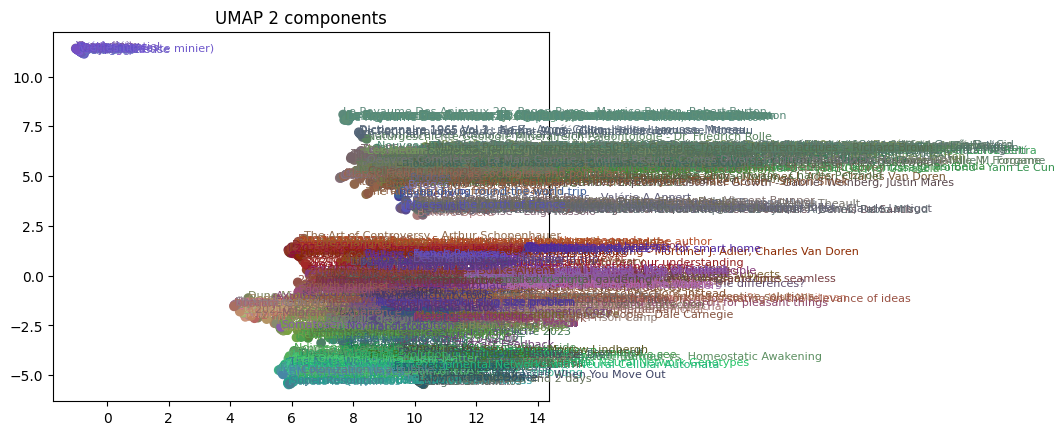

In [40]:
import matplotlib.pyplot as plt
from src.dimensionality_reduction import plot_embeddings

reduced_embeddings = np.load('demo_data/combined_reduced_embeddings.npz')

plot_embeddings(reduced_embeddings["umap2"], reduced_embeddings["pca5"][:, 2:5], "UMAP 2 components", combined_filenames)


# Clustering (WIP)

In [45]:
reduced_npz = np.load('./demo_data/combined_reduced_embeddings.npz', allow_pickle=True)
embedding_npz = np.load('./demo_data/combined_embeddings.npz', allow_pickle=True)

filenames = embedding_npz['filenames']
embeddings = embedding_npz['embeddings']
umap2 = reduced_npz['umap2']
pca5 = reduced_npz['pca5']
tsne2 = reduced_npz['tsne2']


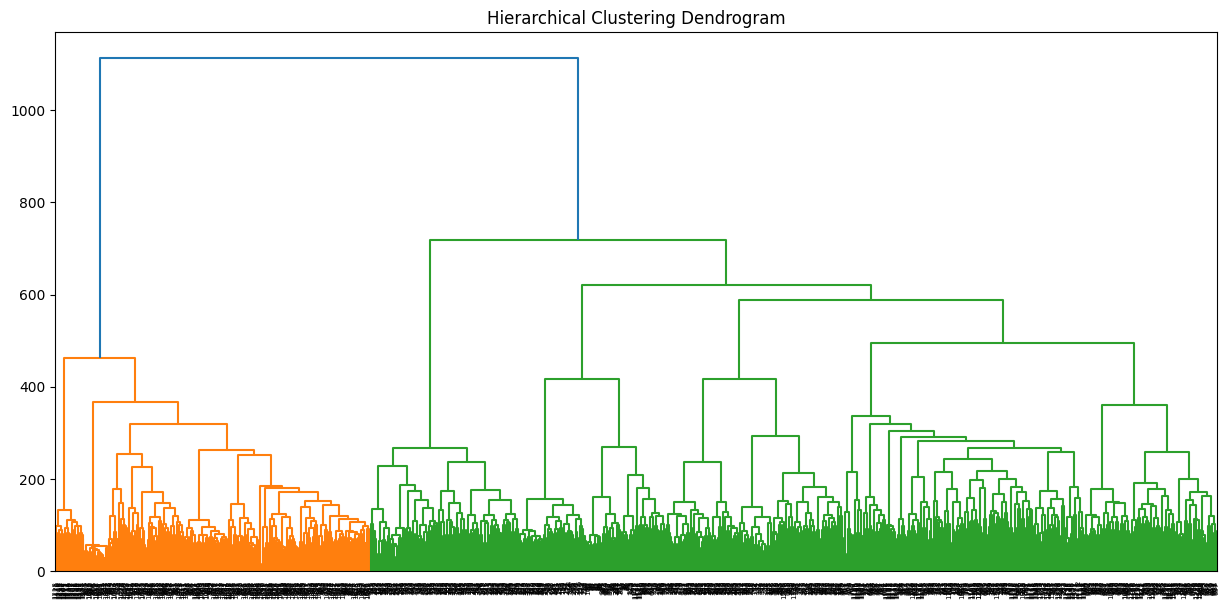

In [46]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster, to_tree
import matplotlib.pyplot as plt

# Perform hierarchical clustering using the 'ward' method
linked = linkage(embeddings, method='ward')

# Plot the dendrogram
plt.figure(figsize=(15, 7))
dendrogram(linked)
plt.title('Hierarchical Clustering Dendrogram')
plt.show()


In [64]:
import matplotlib.colors as mcolors

# Adds colors for linkages by blending the leave colors together, recursively
# if t is 1, color2 is returned, if it is 0, color1 is
def blend_colors(color1, color2, t):
    r1, g1, b1 = color1
    r2, g2, b2 = color2

    r = r1 * (1 - t) + r2 * t
    g = g1 * (1 - t) + g2 * t
    b = b1 * (1 - t) + b2 * t

    return (r, g, b)

colors = pca5[:, 2:5]
num_samples = len(filenames)

for row in linked:
    cluster1_id = int(row[0])
    cluster2_id = int(row[1])

    if cluster1_id < len(filenames): # it is a sample/leaf
        cluster1_size = 1
    else:
        cluster1_size = linked[num_samples - cluster1_id][-1]
    
    if cluster2_id < len(filenames): # it is a sample/leaf
        cluster2_size = 1
    else:
        cluster2_size = linked[num_samples - cluster2_id][-1]

    # If a cluster is huge and is blended with a leaf, the color should be mostly the leaf color
    # Can try different weighting here
    t = cluster2_size / (cluster1_size + cluster2_size)

    color1 = colors[cluster1_id]
    color2 = colors[cluster2_id]

    merged_cluster_color = blend_colors(color1, color2, t)
    
    colors = np.vstack((colors, merged_cluster_color))

# converts rgb (0-1) to hex
colors = [mcolors.to_hex(color) for color in colors]

/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/aidanbx/miniconda/envs/cv/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128140 (\N{LOVE LETTER}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


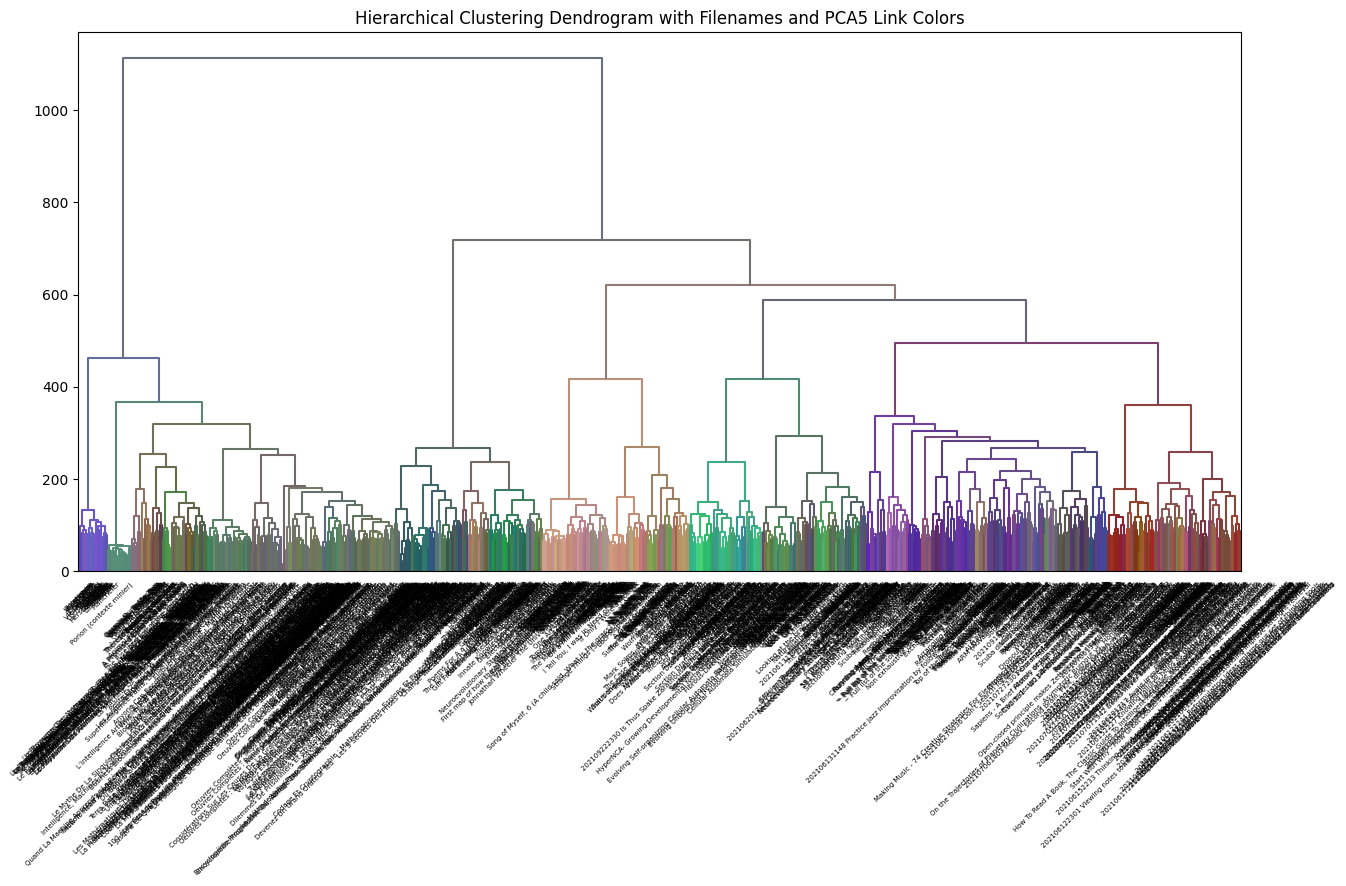

In [74]:
# Plot the dendrogram with custom labels and link colors
plt.figure(figsize=(15, 7))
dendrogram(linked, leaf_rotation=45, labels=[name for name in filenames], link_color_func=lambda link_id: colors[link_id])
plt.title('Hierarchical Clustering Dendrogram with Filenames and PCA5 Link Colors')
plt.show()


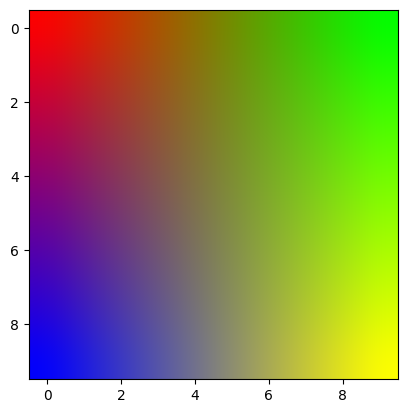

In [63]:
import numpy as np
import matplotlib.pyplot as plt



size = 10

color_top_left = (1, 0, 0)  # Red
color_top_right = (0, 1, 0)  # Green
color_bottom_left = (0, 0, 1)  # Blue
color_bottom_right = (1, 1, 0)  # Yellow

heatmap_colors = np.zeros((size, size, 3))

for i in range(size):
    for j in range(size):
        t1 = i / (size - 1)
        t2 = j / (size - 1)
        
        top_color = blend_colors(color_top_left, color_top_right, t2)
        bottom_color = blend_colors(color_bottom_left, color_bottom_right, t2)
        cell_color = blend_colors(top_color, bottom_color, t1)
        
        heatmap_colors[i, j] = cell_color

plt.imshow(heatmap_colors, origin='upper', interpolation='bicubic')
plt.show()


In [49]:
# Turn the dendrogram into a tree structure
tree = to_tree(linked)

# Define a function to recursively traverse the tree and store information in the leaves
def store_info_in_leaves(node, filenames, embeddings, umap2, pca5, tsne2):
    if node.is_leaf():
        node.data = {
            'filename': filenames[node.id],
            'embedding': embeddings[node.id],
            'umap2': umap2[node.id],
            'pca5': pca5[node.id],
            'tsne2': tsne2[node.id]
        }
    else:
        store_info_in_leaves(node.left, filenames, embeddings, umap2, pca5, tsne2)
        store_info_in_leaves(node.right, filenames, embeddings, umap2, pca5, tsne2)

store_info_in_leaves(tree, filenames, embeddings, umap2, pca5, tsne2)

To perform hierarchical clustering on the combined embeddings, we'll use the hierarchical_clustering.py script. This script will create a tree, compute centroids for each level, and calculate statistics such as the mean distance between centroids at each level.

First, we need to run the hierarchical clustering script with the combined embeddings file and filenames file as inputs.

In [ ]:
!python ./src/hierarchical_clustering.py ./demo_data/combined_embeddings.npz ./demo_data/combined_filenames.csv -o demo_data/level_statistics.txt

In [33]:
embedding_npz.files

NameError: name 'embedding_npz' is not defined